In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

# Example

In [17]:
x = torch.arange(-3.0, 3.0, 0.01)
beta = 1000 # steepness
y = torch.sigmoid(beta * x)

With a high steepness, we basically get a step function. 

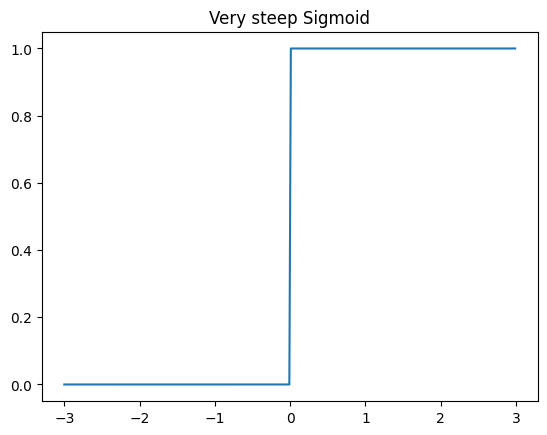

In [18]:
plt.plot(x, y)
plt.title('Very steep Sigmoid');

However, this is totally differentiable:

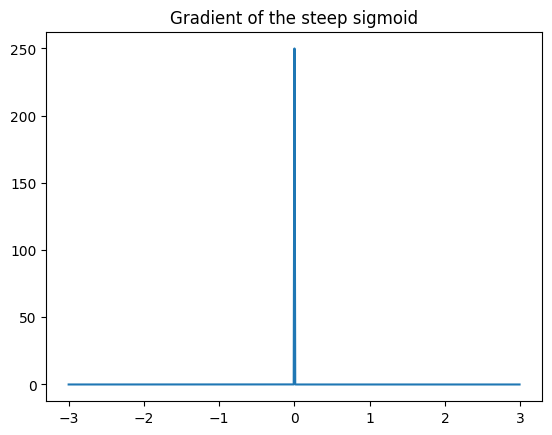

In [19]:
x = torch.arange(-3.0, 3.0, 0.01, requires_grad=True)
beta = 1000
y = torch.sigmoid(beta * x)

y.sum().backward() # the combining function is arbitrary here
plt.plot(x.detach(), x.grad.detach())
plt.title('Gradient of the steep sigmoid');

# Stochastic Neural Network

In [190]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

batch_size = 100

train_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = True, transform = transform)
test_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# features, labels = next(iter(train_loader))

I have changed the random_threshold to be a uniform random number between [-1, 1), slightly different from the [0, 1] implementation in the biological neuron paper. This shouldn't matter though.

In [212]:
class SteepSigmoidNeuron(nn.Module):
    def __init__(self, in_features: int, out_features: int, generator, steepness: int = 100):
        super().__init__()
        self.W = nn.Parameter(torch.randn((in_features, out_features)))
        self.b = nn.Parameter(torch.randn(out_features))
        self.storage = torch.zeros(in_features).to(device)
        self.g = generator
        self.h = nn.ReLU()
        self.steepness = steepness
        self.sigmoid = nn.Sigmoid()
        self.in_features = in_features
        
    def forward(self, x, t):
        # Making x binary using a steep sigmoid
        x = self.sigmoid(self.steepness * x)
        
        # Accumulation
        x = x + self.storage
        self.storage = x.clone().detach()
        
        # Equation 4
        x = (x /  (t + 1)) @ self.W + self.b
        x = self.h(x)
        
        # Equation 5 - except using a steep sigmoid
        random_threshold = torch.rand(1, generator=self.g, device=device) * 2 - 1 # normalising to [-1, 1]
        x = self.sigmoid(self.steepness * (x - random_threshold))
        
        return x # is binary

    def reset_storage(self):
        self.storage = torch.zeros(self.in_features).to(device)

In [215]:
# class EConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
#         super().__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
    
#     def forward(self, x, T):
#         pass
        

In [213]:
class SpikingSigmoidNN(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.g = torch.Generator(device = device).manual_seed(127)
        self.l1 = SteepSigmoidNeuron(in_features, 1024, self.g).to(device)
        self.l2 = SteepSigmoidNeuron(1024, 512, self.g).to(device)
        self.l3 = SteepSigmoidNeuron(512, out_features, self.g).to(device)
        
        # self.fc1 = nn.Linear(in_features, 256)
        # self.fc2 = nn.Linear(256, out_features)
        
        self.squasher = nn.Sigmoid()
        self.activation = nn.ReLU()
        
    def forward(self, init_x, T):
        # The squasher is only necessary for an implementation which requires the data to be within [0, 1]
        # # Paragraph above equation 2
        # init_x = self.squasher(init_x) 
        
        for t in range(T):
            x = self.l1(init_x, t)
            x = self.l2(x, t)
            x = self.l3(x, t)
        return x

    def reset_storage(self):
        for l in [self.l1, self.l2, self.l3]:
            l.reset_storage()
        
model = SpikingSigmoidNN(in_features=28 * 28, out_features=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [214]:
n_epochs = 50
T = 5
losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features.view(-1, 28 * 28), T)
        # outputs = outputs / T # Algorithm Line 15
        # outputs = F.softmax(outputs, dim = 0) # Algorithm Line 16
        loss = criterion(outputs, labels) # Algorithm Line 17

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.reset_storage()
        
        epoch_loss += loss.item()
        if (i+1) % 100 == 0:
            printf(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    losses += [epoch_loss]

Epoch [50/50], Step [600/600], Loss: 2.4327

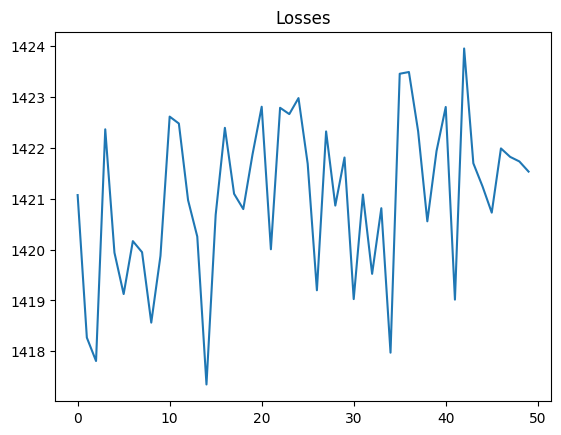

In [211]:
plt.plot(torch.arange(n_epochs), losses)
plt.title('Losses');

# Spiking Stochastic Attempt 2